In [2]:
from fastai2.text.all import *

In this notebook I traing an LM with normalization, softmax instead of linear combination of embeddings and 'the mixer' architecture (multiplying embeddings with the embedding matrix vs using the permutation matrix).

In [3]:
vocab = make_vocab(pd.read_pickle('data/en-100_tok/counter.pkl'), max_vocab=4000)

In [4]:
path = 'data/en-100_tok/'
mult = 4
bs = 80
seq_len = 70

lm = DataBlock(blocks=(TextBlock(vocab=vocab, is_lm=True),),
                get_x=read_tokenized_file,
                get_items=partial(get_text_files, folders=['train', 'valid']),
                splitter=FuncSplitter(lambda itm: itm.parent.name == 'valid'))

dbunch_lm = lm.databunch(path, path=path, bs=bs, seq_len=seq_len)

In [5]:
#export core
class PermuteEmbeddingMixerNorm(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, padding_idx):
        super().__init__()
        
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        self.padding_idx = padding_idx
        
        # to conform to nn.Embedding api
        self.max_norm=None
        self.norm_type=2.0
        self.scale_grad_by_freq=False
        self.sparse = False

        self.weight = nn.Parameter( torch.Tensor(num_embeddings, embedding_dim) )
        nn.init.kaiming_uniform_(self.weight)
        
        self.p_matrix_as_embeddings = nn.Embedding(self.num_embeddings, self.embedding_dim)
        # this is a funny piece of code below - I believe I arrived at this via experimentation,
        # seeing what values would work when fed into the softmax (to give 0 mean and std dev of 1)
        self.p_matrix_as_embeddings.weight = nn.Parameter(torch.eye(self.num_embeddings) * 45 - 0.0075)
        self.p_matrix_as_embeddings.weight.requires_grad = False
        
    def forward(self, words):
        return self.p_matrix_as_embeddings(words).softmax(-1) @ self.normalized_weight()      
    
    def normalized_weight(self):
        w1 = self.weight / self.weight.norm(dim=1).unsqueeze(1)
        w2 = w1 - w1.mean(0)
        w3 = w2 / w2.norm(dim=1).unsqueeze(1)
        return w3
        
    def reset_parameters(self): pass

We need to define a new architecture that will be using our new encoder

In [6]:
#export core
class p_mixer_normAWD_LSTM(AWD_LSTM):
    def __init__(self, vocab_sz, emb_sz, n_hid, n_layers, pad_token=1, hidden_p=0.2, input_p=0.6, embed_p=0.1,
                 weight_p=0.5, bidir=False, packed=False):
        store_attr(self, 'emb_sz,n_hid,n_layers,pad_token,packed')
        self.bs = 1
        self.n_dir = 2 if bidir else 1
        self.encoder = PermuteEmbeddingMixerNorm(vocab_sz, emb_sz, padding_idx=pad_token)
        self.encoder_dp = self.encoder 
        self.rnns = nn.ModuleList([self._one_rnn(emb_sz if l == 0 else n_hid, (n_hid if l != n_layers - 1 else emb_sz)//self.n_dir,
                                                 bidir, weight_p, l) for l in range(n_layers)])
        self.encoder.weight.data.uniform_(-self.initrange, self.initrange)
        self.input_dp = RNNDropout(input_p)
        self.hidden_dps = nn.ModuleList([RNNDropout(hidden_p) for l in range(n_layers)])

In [7]:
#export core
import fastai2
fastai2.text.models.core._model_meta[p_mixer_normAWD_LSTM] = fastai2.text.models.core._model_meta[AWD_LSTM]

In [8]:
#export core

# TODO: add gradient clipping of 0.12 at some point

def opt(params, lr):
    return Adam(params, lr, mom=0.8, sqr_mom=0.99)

drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])

config = dict(
    emb_sz=100,
    n_hid=1150,
    n_layers=3,
    input_p=drops[0],
    hidden_p=drops[1],
    weight_p=drops[2],
    embed_p=drops[3])

awd_lstm_lm_config.update(config)

In [9]:
learn = language_model_learner(
    dbunch_lm,
    p_mixer_normAWD_LSTM,
    opt_func=opt,
    pretrained=False,
    config=awd_lstm_lm_config,
    drop_mult=0.1,
    metrics=[accuracy]
)

In [10]:
learn.fit_one_cycle(1, 5e-3,  moms=(0.8, 0.7, 0.8), wd=1e-7)

epoch     train_loss  valid_loss  accuracy  time    
0         2.945931    2.864700    0.421802  45:32     


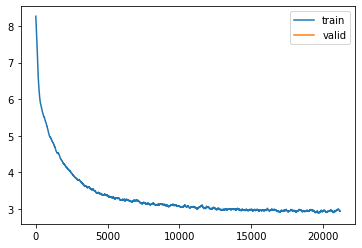

In [11]:
learn.recorder.plot_loss()

In [12]:
# learn.save('pLSTM_mixer_softmax_en')

In [10]:
learn.load('pLSTM_mixer_softmax_en')

In [11]:
learn.validate()

(#2) [2.8647000789642334,0.4218016564846039]

In [12]:
learn.predict('This is', n_words=20)

'This is the only time date that life had occurred in every African Nation . In the late 1970s'

In [13]:
import warnings

@patch_to(LMLearner)
def optimize_permutation(self):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        self.freeze_to(4)
    learn.model[0].encoder.p_matrix_as_embeddings.weight.requires_grad = True
    
@patch_to(LMLearner)
def optimize_model(self):
    self.unfreeze()
    learn.model[0].encoder.p_matrix_as_embeddings.weight.requires_grad = False

In [14]:
learn.optimize_permutation()

In [15]:
preds, targs = learn.get_preds()

In [16]:
def loss():
    preds = []
    targs = []

    learn.model.eval()
    with torch.no_grad():
        for b in learn.dbunch.valid_dl:
            preds.append(learn.model(b[0])[0].detach().cpu())
            targs.append(b[1].detach().cpu())

    preds = torch.cat(preds, 1)
    targs = torch.cat(targs, 1)
    
    return CrossEntropyLossFlat()(preds, targs).item(), accuracy(preds,targs).item()

In [17]:
loss()

(2.868626594543457, 0.42139682173728943)

In [18]:
nn.init.kaiming_normal_(learn.model[0].encoder.p_matrix_as_embeddings.weight)

Parameter containing:
tensor([[-0.0255,  0.0049, -0.0199,  ...,  0.0081,  0.0082, -0.0131],
        [-0.0806, -0.0334, -0.0124,  ...,  0.0132,  0.0270, -0.0086],
        [-0.0216, -0.0060,  0.0199,  ...,  0.0008, -0.0161,  0.0311],
        ...,
        [-0.0165,  0.0041, -0.0146,  ...,  0.0312, -0.0317,  0.0011],
        [-0.0096, -0.0197,  0.0149,  ..., -0.0441,  0.0190,  0.0294],
        [-0.0139, -0.0188, -0.0052,  ...,  0.0046,  0.0004, -0.0044]],
       device='cuda:0', requires_grad=True)

In [19]:
loss()

(6.330158233642578, 0.12923015654087067)

In [20]:
learn.fit(5, 1e-1)

epoch     train_loss  valid_loss  accuracy  time    
0         3.117240    3.055560    0.395325  40:27     
1         3.107133    3.051492    0.396194  40:26     
2         3.132933    3.049636    0.396222  40:27     
3         3.124028    3.049331    0.396321  40:27     
4         3.111895    3.049681    0.396520  40:28     


In [21]:
learn.save('pLSTM_mixer_softmax_p_embs_en')

In [22]:
def hitInTopN(n=1, how_many=None, prints=True):
    data = learn.model[0].encoder.p_matrix_as_embeddings.weight.argsort(descending=True)[10:10+how_many, :n]
    hits = torch.any(data == torch.arange(10, how_many+10).reshape(-1,1).cuda(), -1)
    return hits.float().mean().item()

In [23]:
hitInTopN(1, 100), hitInTopN(5, 100)

(0.8999999761581421, 0.9399999976158142)

In [24]:
acc1 = [(x, hitInTopN(1, x)) for x in range(50,1500,200)]
acc2 = [(x, hitInTopN(2, x)) for x in range(50,1500,200)]
acc3 = [(x, hitInTopN(3, x)) for x in range(50,1500,200)]
acc5 = [(x, hitInTopN(5, x)) for x in range(50,1500,200)]
acc10 = [(x, hitInTopN(10, x)) for x in range(50,1500,200)]

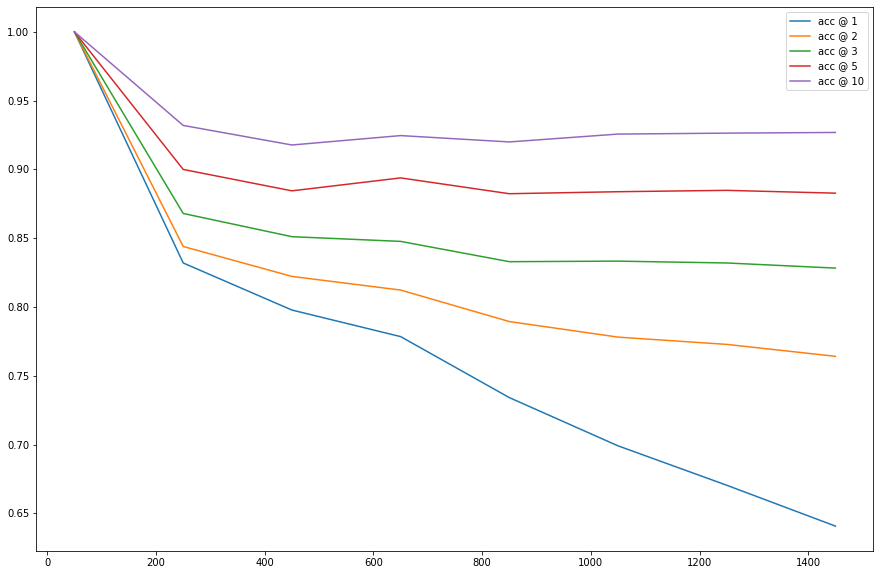

In [25]:
plt.figure(figsize=(15,10))
plt.plot(*zip(*acc1))
plt.plot(*zip(*acc2))
plt.plot(*zip(*acc3))
plt.plot(*zip(*acc5))
plt.plot(*zip(*acc10))
plt.legend([f'acc @ {x}' for x in [1,2,3,5,10]])

In [26]:
data = learn.model[0].encoder.p_matrix_as_embeddings.weight.argsort(descending=True)[:, :5]
print('actual word\t\tpredictions\n')
for i in range(60, 80):
    print(f'{learn.dbunch.vocab[i]}\t\t{[learn.dbunch.vocab[idx] for idx in data[i]]}')

actual word		predictions

two		['two', 'a', 'another', 'one', 'an']
or		['nor', 'xxmaj', 'or', '-', 'and']
have		['have', 'u.s', 'mrs', 'ways', 'dr']
who		['who', 'vice', 'duke', 'prince', 'jones']
new		['new', 'united', 'six', 'seven', 'nine']
been		['was', 'fallen', 'severely', 'widely', 'been']
has		['has', 'serves', 'wasn', 'doesn', 'acts']
@,@		['@,@', 'kilometres', '<', 'km2', 'km']
she		['she', 'lisa', 'madonna', 'bart', 'beyoncé']
when		['when', 'at', 'shortly', 'during', 'after']
time		['time', 'badly', 'night', 'shortly', 'straight']
during		['during', 'in', 'at', 'was', 'en']
other		['other', 'very', 'too', 'extremely', 'another']
would		['would', 'upon', 'towards', 'helped', 'toward']
into		['into', 'handed', 'enters', 'toward', 'seriously']
all		['all', 'every', 'any', 'what', 'our']
i		['i', '<', 'you', 'r', 'f']
more		['more', 'highly', 'a', 'so', 'an']
0		['50', '1', 'xxrep', '3', '2']
while		['whilst', 'six', 'four', 'five', 'three']


In [1]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_data.ipynb.
Converted 01_train_LM_en.ipynb.
Converted 02_train_LM_es.ipynb.
Converted 03_translate_en_to_es.ipynb.
Converted 04_LM_with_normalized_embeddings.ipynb.
Converted 04a_LM_with_normalized_embeddings_mixer_softmax.ipynb.
Converted 05_aligning_the_embeddings_using_vecmap.ipynb.
Converted 99_index.ipynb.
Converted Untitled.ipynb.
